# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
from skimage.util.shape import view_as_windows
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap
from numpy.lib.stride_tricks import as_strided
import pickle
from sklearn.mixture import GaussianMixture


## F-Score

In [2]:
orig_data = fits.getdata("subcube_7002.fits")
seg_data = fits.getdata("segcube_7002.fits")
mto_data = fits.getdata("segmcube.fits")

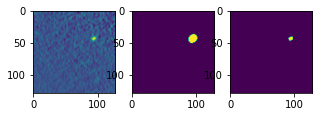

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (5, 5))
ax1.imshow(orig_data[21])
ax2.imshow(seg_data[21])
ax3.imshow(mto_data[21])

In [4]:
def f_score(inter, all_of):
    dice = 2*inter/all_of
    return dice
def intersection(A, B):
    return np.nansum(np.logical_and(A, B).astype(int))

def all_AB(A, B):
    return np.nansum(A) + np.nansum(B)

In [5]:
gt = (seg_data).flatten().tolist()
pred = (mto_data).flatten().tolist()
intersection(gt, pred), all_AB(gt, pred), f_score(intersection(gt, pred), all_AB(gt, pred))

(842, 6868, 0.24519510774606873)

## Load model

Properties of pre-trained model

In [6]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 0
model_name = model
date_str = ""
save = '../saved_models_12052021_183655_/fold_' + str(k) + '_checkpoints/'

Load pre-trained model

In [7]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
model_loc = "../../../../VNET__BEST.pth"
args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
# args = argsclass('VNET', 'adam', 1e-2, 1, 2, "../saved_models_12052021_165424_/fold_" + str(k) + "_checkpoints/VNET_/VNET__BEST.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45603934


3

In [278]:
train_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
train_df["epoch"] = train_df["epoch"].str.split("Loss", expand=True)[0]
val_df["epoch"] = val_df["epoch"].str.split("Loss", expand=True)[0]
train_df["loss"] = train_df["loss"].str.split(" ", expand=True)[0]
val_df["loss"] = val_df["loss"].str.split(" ", expand=True)[0]

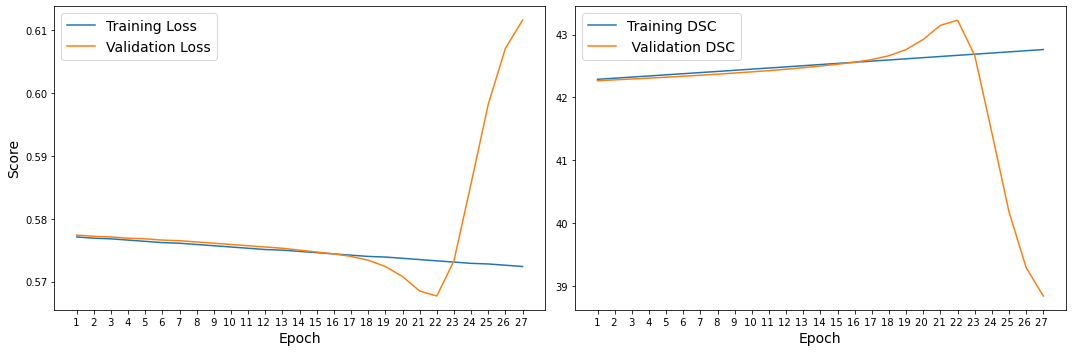

In [287]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[0].set_xlabel("Epoch", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Score", fontsize=14)
# axes[1].set_ylabel("Score")
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
fig.tight_layout()

# Evaluate Model

Load the test subcubes

In [10]:
def prepare_data(data):
    interval = ZScaleInterval()
    return interval(np.nan_to_num(np.moveaxis(data, 0, 2)))

def post_process(tensor):
    out_np = tensor.squeeze()[1].numpy()
    smoothed_gal = ndi.gaussian_filter(out_np, sigma=1)
#     smoothed_gal = out_np
#     t = np.mean(smoothed_gal) + np.std(smoothed_gal)
#     new_mask = (smoothed_gal > t)
#     object_labels = skmeas.label(new_mask)
    classif = GaussianMixture(n_components=2)
    classif.fit(smoothed_gal.reshape((smoothed_gal.size, 1)))
    threshold = np.mean(classif.means_)
    new_mask = smoothed_gal > threshold
    return new_mask

In [11]:
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
orig_subcube = orig_data[133:197, 800:800+128, 1500:1500+128]
real_subcube = realseg_data[133:197, 800:800+128, 1500:1500+128]

In [115]:
model.eval()
prepared_data = prepare_data(orig_subcube)
mask_tensor = torch.FloatTensor(np.moveaxis(real_subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
#     out_mask = model.inference(mask_tensor)

In [ ]:
object_labels = post_process(out_cube)
# object_labels_mask = post_process(out_mask)
y_true = np.moveaxis(realseg_data, 0, 2)
mask_labels = skmeas.label(np.moveaxis(real_subcube.astype(bool), 0, 2))

gt = (object_labels).flatten().tolist()
pred = (y_true).flatten().tolist()
f_score(intersection(gt, pred), all_AB(gt, pred))

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(prepared_data[..., 34])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")


im3 = axes[1].imshow(realseg_data[34])
cax3 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[1].set_title("Ground Truth Cube")

im1 = axes[2].imshow(out_cube.squeeze()[0][..., 34])
cax1 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[2].set_title("Inference")

im2 = axes[3].imshow(object_labels[..., 34])
cax2 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[3].set_title("Smoothed and Thresholded Inference")


# im4 = axes[4].imshow(out_mask.squeeze()[0][..., 34])
# cax4 = make_axes_locatable(axes[4]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im4, cax=cax4)
# axes[4].set_title("Inference on GT")

# im5 = axes[5].imshow(object_labels_mask[..., 34])
# cax5 = make_axes_locatable(axes[5]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im5, cax=cax5)
# axes[5].set_title("Post-Processed Inference on GT")

fig.tight_layout()

In [43]:
# test_file = "../saved_models_12052021_165424_/test_list.txt"
test_file = "../saved_models_12052021_183655_/test_list.txt"

params = {'batch_size': 1,
        'shuffle': True,
        'num_workers': 1}
with open(test_file, "rb") as fp:
    test_list = pickle.load(fp)
dataset_test = SegmentationDataSet(inputs=[],
                                    targets=[],
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root=root,
                                    list=test_list)
dataloader_test = DataLoader(dataset=dataset_test, **params)

In [44]:
dataset_test.list = [(["." + i[0][0], "." + i[0][1]], i[1], i[2], i[3]) for i in dataset_test.list]

0.0


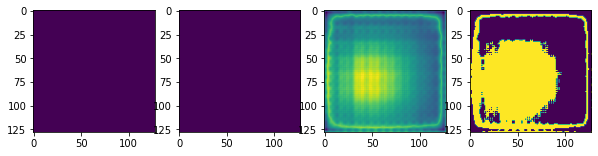

0.0


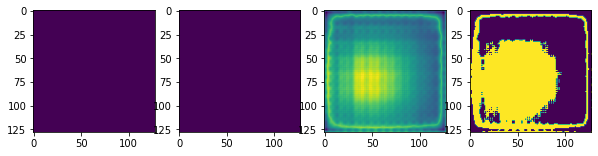

In [88]:
intersections = 0
all_or = 0
with torch.no_grad():
    for batch_idx, input_tuple in enumerate(dataloader_test):
        input_tensor, target = input_tuple
        out_cube = model.inference(input_tensor)# Grab in numpy array
        out_np = out_cube.squeeze()[1].numpy()
        target_np = target.squeeze().numpy()
        new_mask= post_process(out_cube)
        gt = (target_np).flatten().tolist()
        pred = (new_mask).flatten().tolist()
        intersections += np.nansum(np.logical_and(gt, pred).astype(int))
        all_or += np.nansum(pred) + np.nansum(gt)
        print(2*np.nansum(np.logical_and(gt, pred).astype(int))/(np.nansum(gt) + np.nansum(pred)))
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        axes[0].imshow(input_tensor.squeeze().numpy()[..., 34])
        axes[1].imshow(target_np[..., 34])
        axes[2].imshow(out_np[..., 34])
        axes[3].imshow(new_mask[..., 34])
        plt.show()
    dice_losses = 2*intersections/all_or

In [101]:
dice_losses

0.0

## Inference on a full cube

In [9]:
def save_sliding_window(arr_shape, dims, overlaps, f_in, f_tar):
    x, y, z =(((np.array(arr_shape) - np.array(dims))
                      // np.array(np.array(dims)-np.array(overlaps))) + 1)

    sliding_window_indices = []
    count = 0
    for i in range(x):
        for j in range(y):
            for k in range(z):
                x1, x2 = dims[0]*i-overlaps[0]*i, dims[0]*(i+1)-overlaps[0]*i
                y1, y2 = dims[1]*j-overlaps[1]*j, dims[1]*(j+1)-overlaps[1]*j
                z1, z2 = dims[2]*k-overlaps[2]*k, dims[2]*(k+1)-overlaps[2]*k
                sliding_window_indices.append(([f_in, f_tar], [x1, x2], [y1, y2], [z1, z2]))
                count += 1
                print("\r", count*100/(x*y*z), end="")
    print()
    return sliding_window_indices

In [19]:
dims = [128, 128, 64]
overlaps = [15, 20, 20]

Stitch together sliding window

In [92]:
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
reshaped_orig_data = np.moveaxis(orig_data, 0, 2)
interval = ZScaleInterval()
arr_shape = reshaped_orig_data.shape
empty_arr = np.empty(arr_shape)
empty_arr[:] = np.nan
# .fill(numpy.nan)

In [93]:
x, y, z =(((np.array(arr_shape) - np.array(dims))
                  // np.array(np.array(dims)-np.array(overlaps))) + 1)
model.eval()
for i in range(x):
    for j in range(y):
#         for k in range(z):
        x1, x2 = dims[0]*i-overlaps[0]*i, dims[0]*(i+1)-overlaps[0]*i
        y1, y2 = dims[1]*j-overlaps[1]*j, dims[1]*(j+1)-overlaps[1]*j
#             z1, z2 = dims[2]*k-overlaps[2]*k, dims[2]*(k+1)-overlaps[2]*k
        z1, z2 = 133, 197
        prepared_data1 = interval(np.nan_to_num(reshaped_orig_data[x1:x2, y1:y2, z1:z2]))
        data_loader_tensor1 = torch.FloatTensor(prepared_data1.astype(np.float32)).unsqueeze(0)[None, ...]
        with torch.no_grad():
            out_cube1 = model.inference(data_loader_tensor1)
            out_np1 = out_cube1.squeeze()[1].numpy()
        empty_arr[x1:x2, y1:y2, z1:z2] = np.nanmean(np.array([out_np1, empty_arr[x1:x2, y1:y2, z1:z2]]), axis=0)
        if j ==2:
            break
    if i ==2:
        break

Threshold and add limitations

In [101]:
def post_process_seg(new_subcube, orig_subcube):
    smoothed_gal = ndi.gaussian_filter(new_subcube, sigma=3)
    binary_im = smoothed_gal > np.mean(smoothed_gal) + np.std(smoothed_gal)
    object_labels = skmeas.label(binary_im)
    some_props = skmeas.regionprops(object_labels)
    for i in range(len(some_props)):
        bb = some_props[i].bbox
        flux = np.nansum(orig_subcube[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]])
        cond = (bb[3]-bb[0] > 35) | (bb[4]-bb[1] > 35) | (bb[5]-bb[2] > 35) | (flux < 0.1)
        if cond:
            binary_im[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]] = 0
    return binary_im

In [110]:
real_subcube = np.moveaxis(realseg_data, 0, 2)[:354, :344, 133:197]
orig_subcube = np.moveaxis(orig_data, 0, 2)[:354, :344, 133:197]
new_subcube = empty_arr[:354, :344, 133:197]
object_labels = skmeas.label(real_subcube)
some_props = skmeas.regionprops(object_labels)
print("Number of inserted sources =", len(some_props))

Number of inserted sources = 2


In [111]:
binary_im = post_process_seg(new_subcube, orig_subcube)
object_labels = skmeas.label(binary_im)
some_props = skmeas.regionprops(object_labels)
print("Number of found sources =", len(np.unique(object_labels)))

Number of found sources = 3


View output

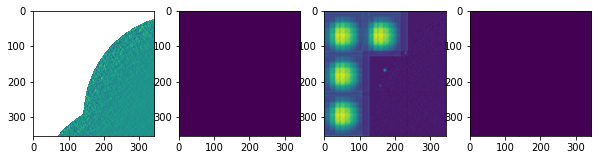

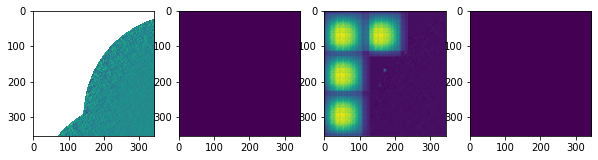

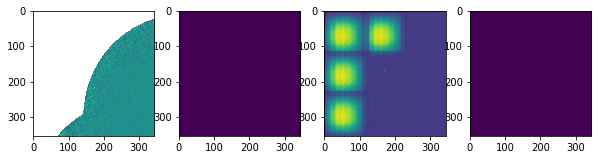

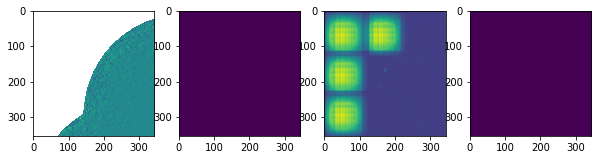

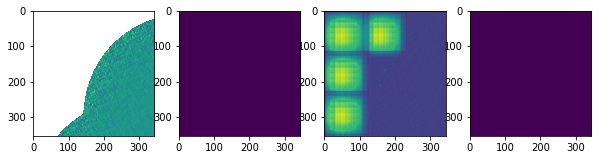

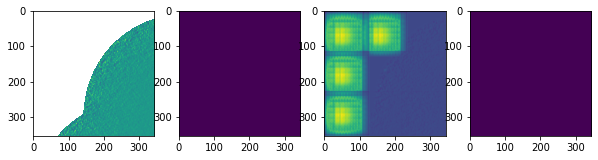

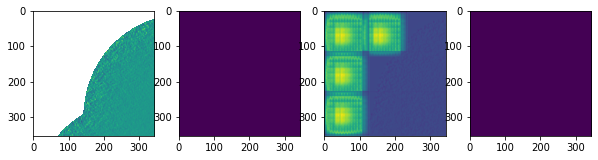

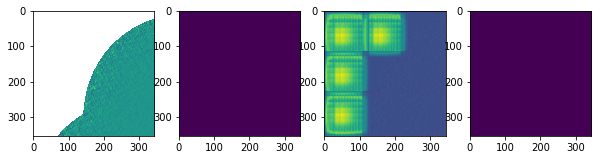

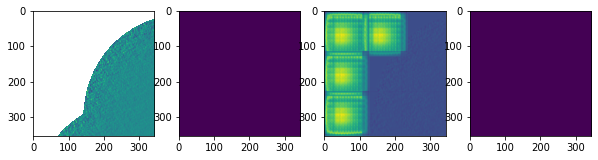

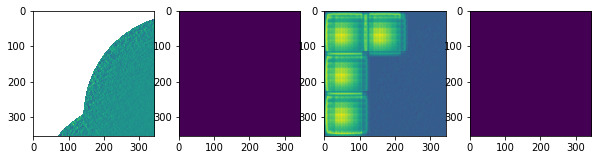

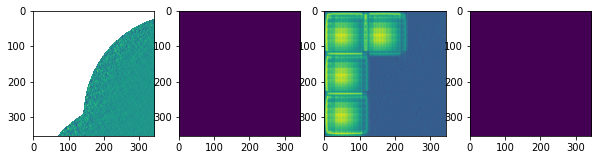

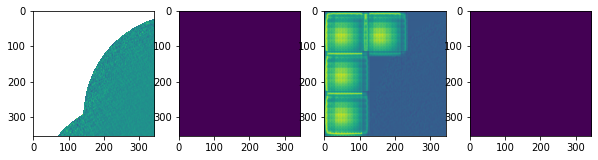

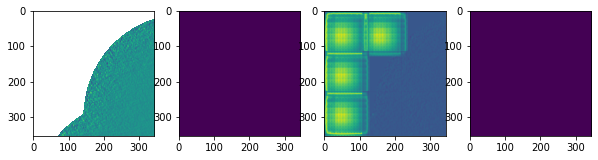

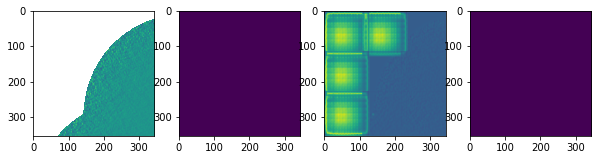

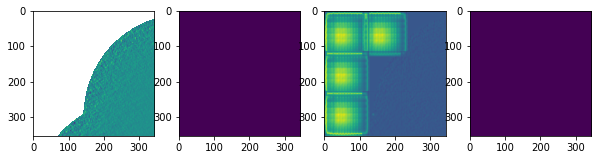

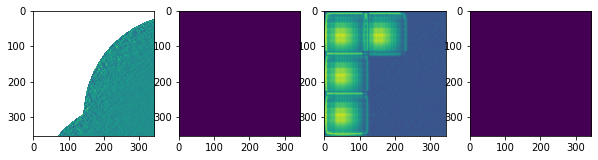

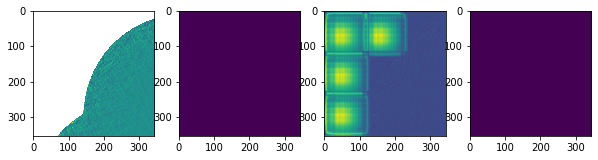

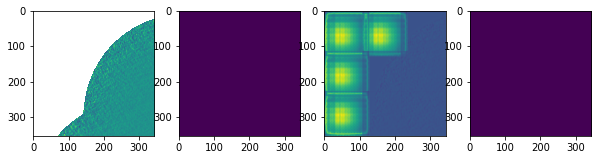

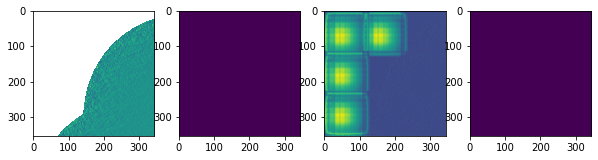

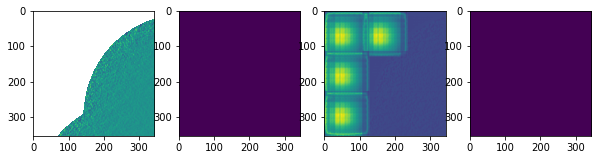

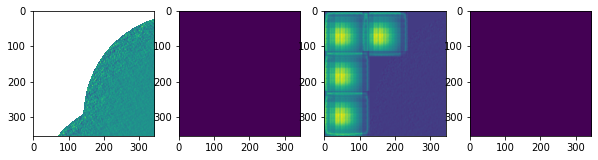

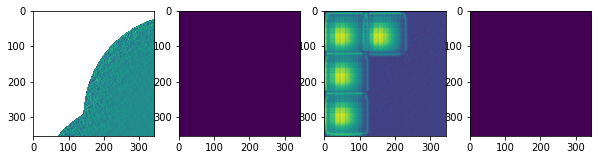

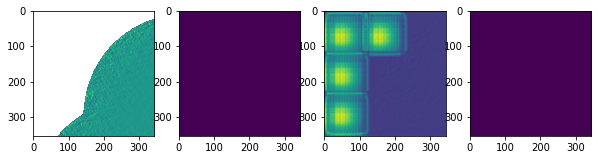

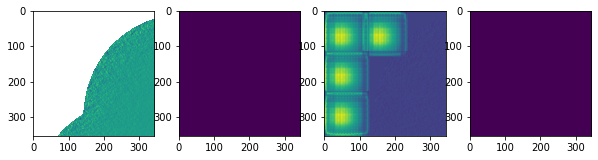

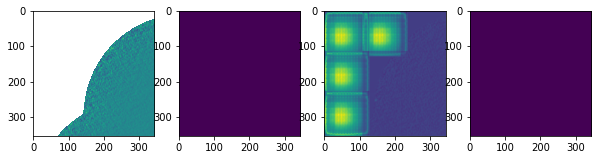

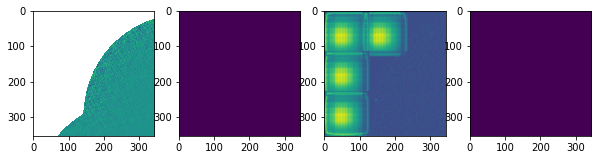

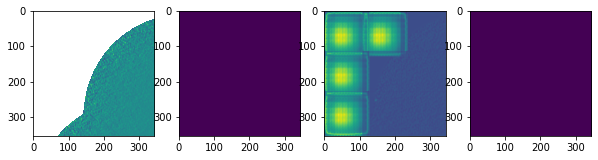

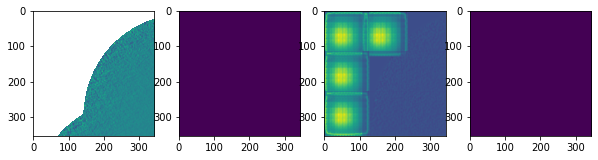

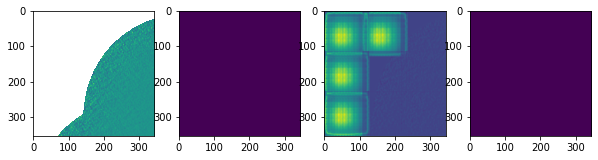

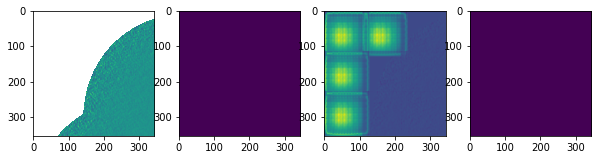

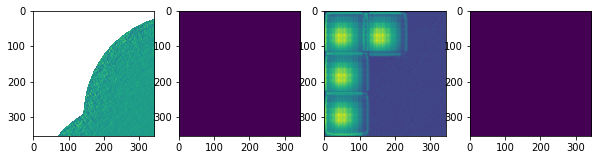

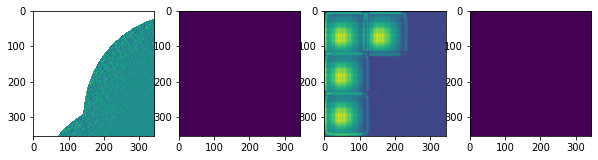

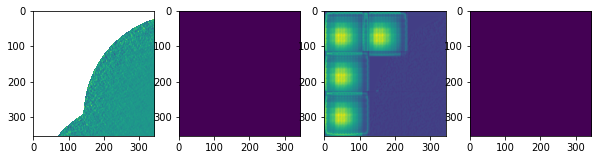

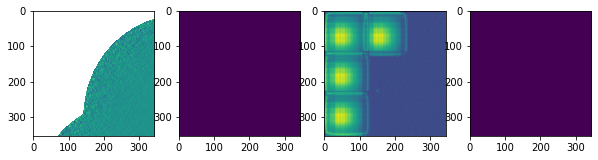

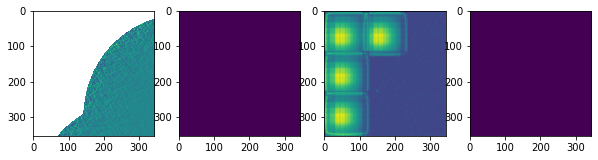

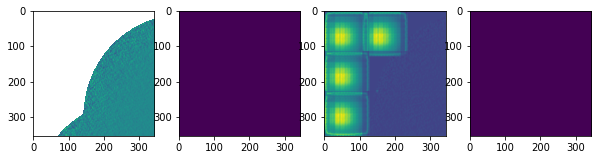

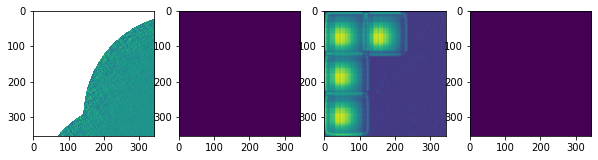

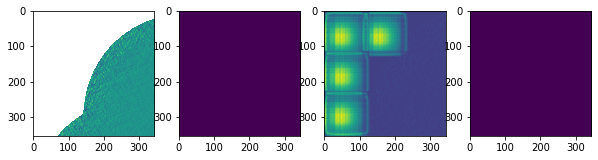

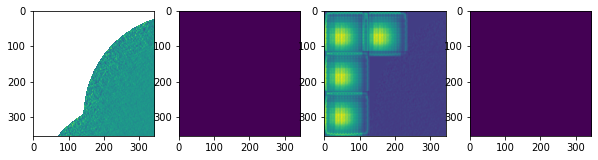

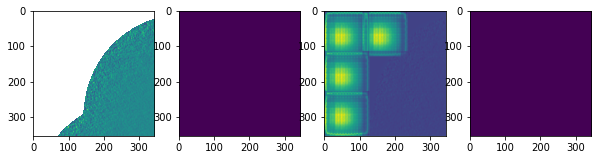

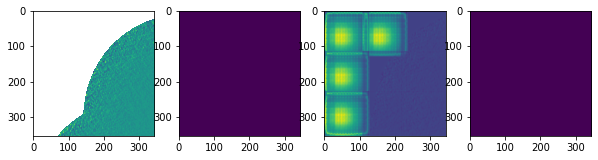

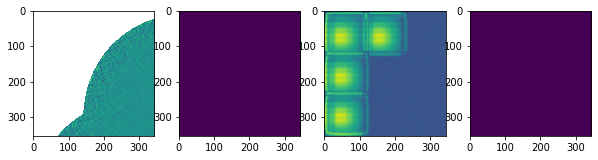

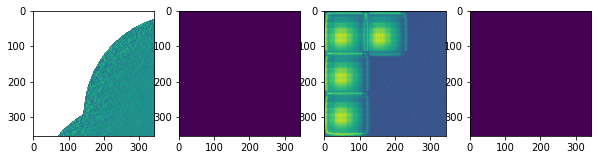

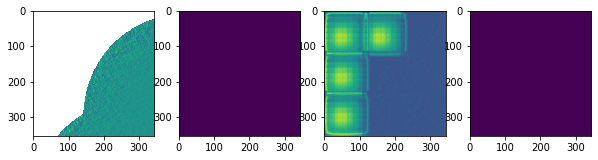

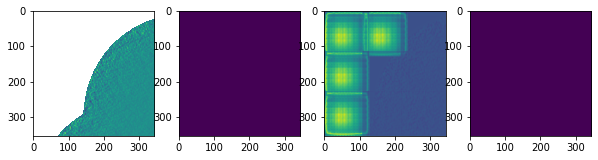

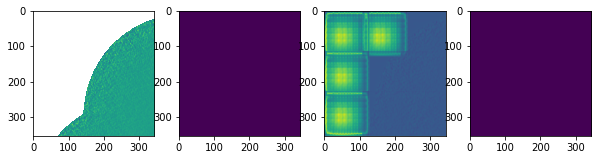

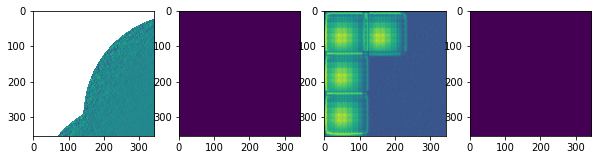

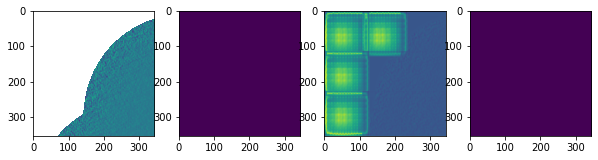

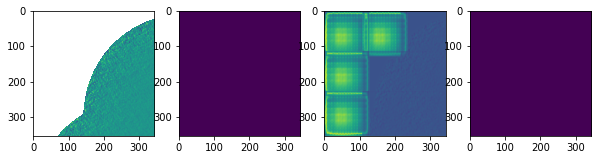

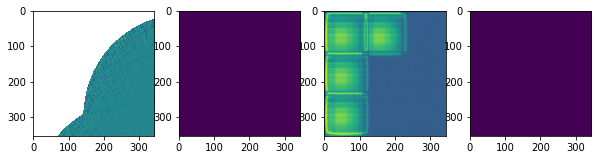

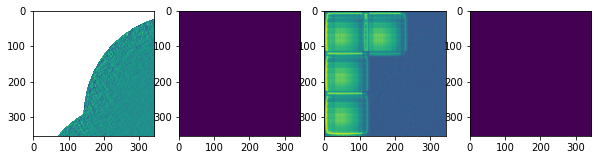

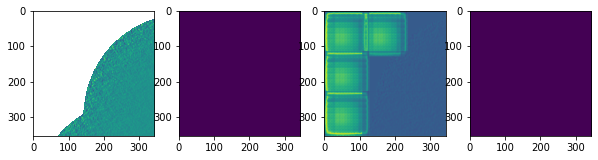

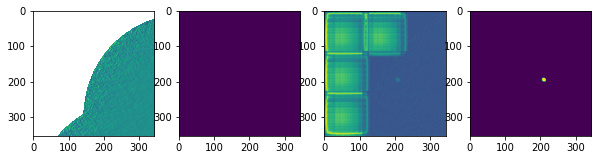

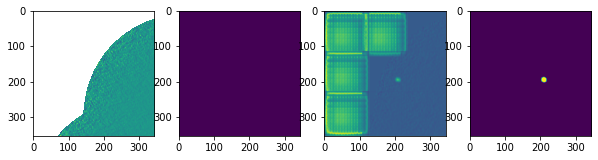

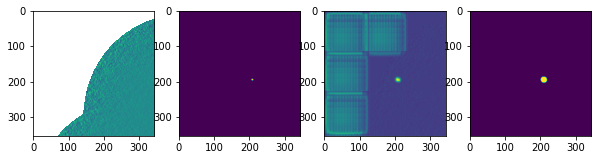

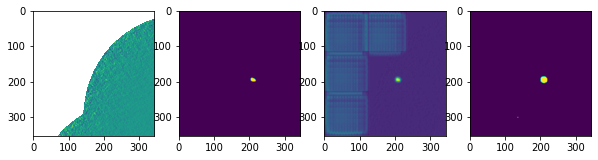

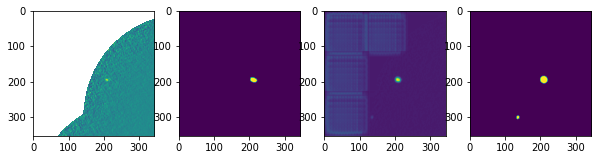

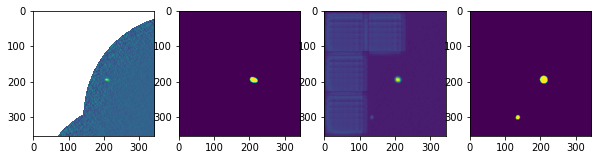

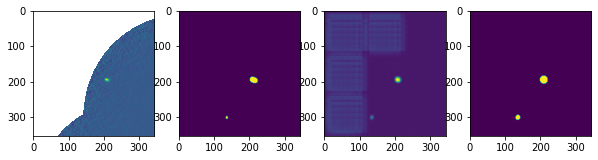

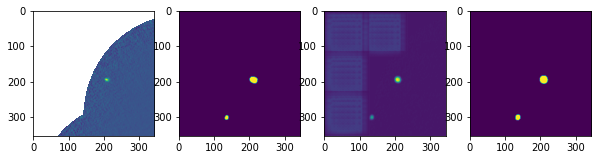

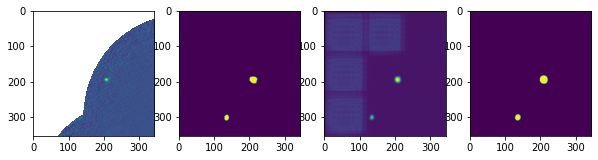

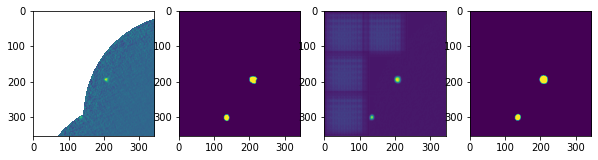

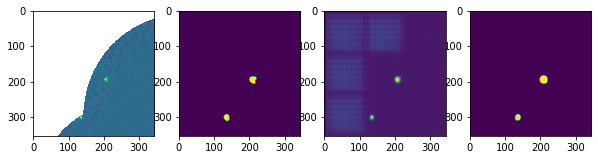

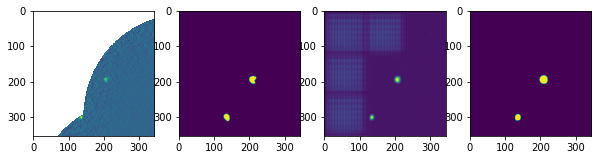

In [114]:
for z in range(new_subcube.shape[-1]):
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes[0].imshow(orig_subcube[..., z])
    axes[1].imshow(real_subcube[..., z])
    axes[2].imshow(new_subcube[..., z])
    axes[3].imshow(binary_im[..., z])
    plt.show()